# Predict Stock Price Trend Using LSTM


## Copy Dataset

In [2]:
# get the train and test data from drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!cp '/content/gdrive/My Drive/App/RNN/Google_Stock_Price_Train.csv' /content
!cp '/content/gdrive/My Drive/App/RNN/Google_Stock_Price_Test.csv' /content

## Import Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
print('numpy:', np.__version__)
print('pandas:', pd.__version__)

numpy: 1.16.3
pandas: 0.24.2


## Read Dataset

In [0]:
train_df = pd.read_csv('./Google_Stock_Price_Train.csv', index_col='Date', parse_dates=['Date'])

In [7]:
train_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [8]:
train_df.shape

(1258, 5)

In [9]:
train_df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2016-12-23,790.90,792.74,787.28,789.91,"623,400"
2016-12-27,790.68,797.86,787.66,791.55,"789,100"
2016-12-28,793.70,794.23,783.20,785.05,"1,153,800"
2016-12-29,783.33,785.93,778.92,782.79,"744,300"
2016-12-30,782.75,782.78,770.41,771.82,"1,770,000"


## EDA

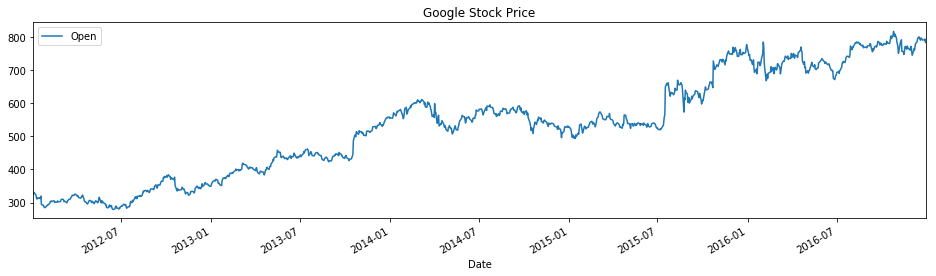

In [10]:
train_df['Open'][:'2016'].plot(figsize=(16,4),legend=True)
plt.title('Google Stock Price')
plt.show()

## Data Processing

### Get the Open price info

In [0]:
# let's get the Open prices as numpy array.
Open_price_arr = train_df.iloc[:,0:1].values

In [12]:
Open_price_arr[0:5]


array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

### Scale the data in the range [0,1]

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
sc = MinMaxScaler(feature_range=(0,1))

In [0]:
Open_prices_arr_scaled = sc.fit_transform(Open_price_arr)

In [16]:
Open_prices_arr_scaled[0:5]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225]])

### Create Dataset with Timestep

The idea is LSTM can remember the state (aka dependencies). So create the dataset in such a way that, the current trend of the stock price depends on the earlier stock prices. So, let's create the timestep of size 60, ie., the current output depends on the previous sixty days prices.

In [17]:
len(Open_prices_arr_scaled)

1258

In [0]:
X_train = []
Y_train = []

for i in range(60, len(Open_prices_arr_scaled)):
  X_train.append(Open_prices_arr_scaled[i-60:i, 0])
  Y_train.append(Open_prices_arr_scaled[i,0])

In [0]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [20]:
print(len(X_train[0]))
print(X_train[0])
print(Y_train[0])

60
[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225 0.0643277
 0.0585423  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514
 0.02797827 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334
 0.01642607 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665
 0.0433812  0.04475779 0.04790163 0.0440695  0.04648783 0.04745517
 0.04873875 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099
 0.04356723 0.04286033 0.04602277 0.05398467 0.05738894 0.05714711
 0.05569611 0.04421832 0.04514845 0.04605997 0.04412531 0.03675869
 0.04486941 0.05065481 0.05214302 0.05612397 0.05818885 0.06540665
 0.06882953 0.07243843 0.07993526 0.07846566 0.08034452 0.08497656]
0.08627874097775134


In [21]:
X_train.shape

(1198, 60)

### Reshape 

In [0]:
## reshape for efficient modelling

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1) )

In [23]:
X_train.shape

(1198, 60, 1)

## Get Test Dataset

In [0]:
test_df = pd.read_csv('./Google_Stock_Price_Test.csv', index_col='Date', parse_dates=['Date'])

In [25]:
test_df.shape

(20, 5)

In [26]:
test_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"


In [0]:
test_open_price_arr = test_df.iloc[:, 0:1].values

In [28]:
test_open_price_arr[0:5]

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ]])

### Build test dataset.

Note that for test dataset as well, we need 60 timesteps for prediction.
So, let's concatenate the train and test data and build the test dataset with timesteps.

In [29]:
train_df['Open'].head()

Date
2012-01-03    325.25
2012-01-04    331.27
2012-01-05    329.83
2012-01-06    328.34
2012-01-09    322.04
Name: Open, dtype: float64

In [0]:
real_stock_price = test_df['Open'].values

In [32]:
real_stock_price

array([778.81, 788.36, 786.08, 795.26, 806.4 , 807.86, 805.  , 807.14,
       807.48, 807.08, 805.81, 805.12, 806.91, 807.25, 822.3 , 829.62,
       837.81, 834.71, 814.66, 796.86])

In [0]:
Open_price_total = pd.concat((train_df['Open'], test_df['Open']), axis =0)


In [34]:
len(Open_price_total)

1278

In [0]:
# the timestep is 60, ie., 3 months data.
# so for prediction, we need 3 months history Open price as well.
#
# get the test data along with past 60 days Open price info
#
test_inputs = Open_price_total[len(Open_price_total) - len(test_df) - 60:].values

In [37]:
test_inputs.shape

(80,)

In [0]:

test_inputs = test_inputs.reshape(-1, 1)

In [39]:
test_inputs.shape

(80, 1)

In [0]:
#test_inputs

In [0]:
# scale the test data
test_inputs = sc.transform(test_inputs)

In [0]:
# build the dataset with 60 timestep for each test data value for prediction
X_test = []

for i in range(60, len(test_inputs)):
  X_test.append(test_inputs[i-60:i, 0])
  
X_test = np.array(X_test)

In [42]:
X_test.shape

(20, 60)

In [43]:
X_test[1]

array([0.93113327, 0.92750577, 0.94415507, 0.93876032, 0.93403527,
       0.93483518, 0.9313937 , 0.94636878, 0.96569685, 0.97510976,
       0.95966962, 0.97808617, 1.        , 0.98076494, 0.97083116,
       0.98450406, 0.96054394, 0.9371419 , 0.92841729, 0.90804747,
       0.8771858 , 0.92153434, 0.93809063, 0.93165414, 0.95254483,
       0.88812412, 0.88637547, 0.87032145, 0.88563137, 0.90743359,
       0.91571173, 0.89941588, 0.91805566, 0.9089404 , 0.9024853 ,
       0.89456061, 0.91600938, 0.9132934 , 0.88979835, 0.86589404,
       0.89030062, 0.90335962, 0.89642086, 0.91777662, 0.93176576,
       0.94114145, 0.95762334, 0.96413424, 0.96402262, 0.96971501,
       0.95077759, 0.96294367, 0.96123223, 0.95475854, 0.95204256,
       0.95163331, 0.95725128, 0.93796041, 0.93688146, 0.92955205])

In [0]:
# reshape in 3 dim.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [45]:
X_test.shape

(20, 60, 1)

In [0]:
#X_test[1]

## Build Model Using LSTM

In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [0]:
# build sequential model

regressor = Sequential()

In [48]:
# add LSTM and dropout for regularization
#?LSTM()
## return_sequences => return the last output in the output sequences
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(rate=0.2)) # drop 20 percent of inputs 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Add a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))


In [0]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [51]:
# Fitting the RNN to the Training set
regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0554
Epoch 2/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0065
Epoch 3/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0053
Epoch 4/100
1198/1198 [==============================] - 13s 11ms/step - loss: 0.0048
Epoch 5/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0054
Epoch 6/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0047
Epoch 7/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0049
Epoch 8/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0049
Epoch 9/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0044
Epoch 10/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0047
Epoch 11/100
1198/1198 [==============================] - 14s 12ms/step - loss: 0.0038
Epoc

### Make Predictions and Visualize Results

### Predict

In [0]:
pred = regressor.predict(X_test)

In [0]:
pred =sc.inverse_transform(pred)

In [54]:
pred[0]

array([765.01465], dtype=float32)

In [55]:
pred.shape

(20, 1)

In [56]:
pred[0]

array([765.01465], dtype=float32)

In [57]:
test_df['Open'].shape

(20,)

### Visualize the results


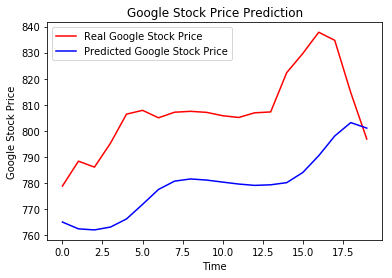

In [58]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

### Evaluate Model

In [59]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, pred))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 30.538622335768956.


## Build Model Using GRU

**Gated Recurrent Unit**

* GRU does not have a memory unit like LSTM
* Only two gates (reset and update) when compared with 3 in the case of LSTM.
* Fewer parameters and hence less training time.
* For large data, LSTM has better expressiveness.

In [0]:
from keras.layers import GRU

In [0]:
?GRU

In [0]:
## Build model using GRU

regressorGRU = Sequential()

In [0]:
## return_sequences => return the last output in the output sequences
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressorGRU.add(Dropout(rate=0.2)) # drop 20 percent of inputs 

# Add a second LSTM layer and some Dropout regularisation
regressorGRU.add(GRU(units = 50, return_sequences = True))
regressorGRU.add(Dropout(0.2))

# Add a third LSTM layer and some Dropout regularisation
regressorGRU.add(GRU(units = 50, return_sequences = True))
regressorGRU.add(Dropout(0.2))

# Add a fourth LSTM layer and some Dropout regularisation
regressorGRU.add(GRU(units = 50))
regressorGRU.add(Dropout(0.2))

# Add the output layer
regressorGRU.add(Dense(units = 1))

In [0]:
# Compiling the RNN
regressorGRU.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [70]:
# Fitting the RNN to the Training set
regressorGRU.fit(X_train, Y_train, epochs = 100, batch_size = 32)


Epoch 1/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0420
Epoch 2/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0071
Epoch 3/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0055
Epoch 4/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0051
Epoch 5/100
1198/1198 [==============================] - 10s 9ms/step - loss: 0.0042
Epoch 6/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0041
Epoch 7/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0040
Epoch 8/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0039
Epoch 9/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0037
Epoch 10/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0040
Epoch 11/100
1198/1198 [==============================] - 10s 9ms/step - loss: 0.0040
Epoch 12/100
1198/1198 [==============================] - 11s 

### Predict

In [0]:
GRU_pred = regressorGRU.predict(X_test)
GRU_pred = sc.inverse_transform(GRU_pred)

### Visualize

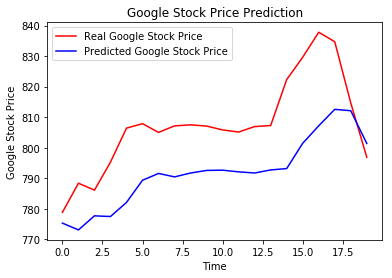

In [74]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(GRU_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

### Evaluate Model

In [75]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, GRU_pred))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 17.858374315838958.


## Build Model Using Bi-directional LSTM

In [0]:
from keras.layers import Bidirectional

In [0]:
regressorBi = Sequential()

In [0]:
?Bidirectional

In [0]:
## return_sequences => return the last output in the output sequences
regressorBi.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1), merge_mode='concat'))
regressorBi.add(Dropout(rate=0.2)) # drop 20 percent of inputs 

# Add a second Bi/LSTM layer and some Dropout regularisation
regressorBi.add(Bidirectional(LSTM(units = 50, return_sequences = True), merge_mode='concat'))
regressorBi.add(Dropout(0.2))

# Add a third Bi/LSTM layer and some Dropout regularisation
regressorBi.add(Bidirectional(LSTM(units = 50, return_sequences = True), merge_mode='concat'))
regressorBi.add(Dropout(0.2))

# Add a fourth LSTM layer and some Dropout regularisation
regressorBi.add(Bidirectional(LSTM(units = 50), merge_mode='concat'))
regressorBi.add(Dropout(0.2))

# Add the output layer
regressorBi.add(Dense(units = 1))

In [0]:
# Compiling the RNN
regressorBi.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [88]:
# Fitting the RNN to the Training set
regressorBi.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0322
Epoch 2/100
1198/1198 [==============================] - 26s 22ms/step - loss: 0.0051
Epoch 3/100
1198/1198 [==============================] - 25s 21ms/step - loss: 0.0042
Epoch 4/100
1198/1198 [==============================] - 25s 20ms/step - loss: 0.0036
Epoch 5/100
1198/1198 [==============================] - 25s 21ms/step - loss: 0.0036
Epoch 6/100
1198/1198 [==============================] - 25s 21ms/step - loss: 0.0035
Epoch 7/100
1198/1198 [==============================] - 24s 20ms/step - loss: 0.0036
Epoch 8/100
1198/1198 [==============================] - 26s 22ms/step - loss: 0.0030
Epoch 9/100
1198/1198 [==============================] - 25s 21ms/step - loss: 0.0032
Epoch 10/100
1198/1198 [==============================] - 24s 20ms/step - loss: 0.0030
Epoch 11/100
1198/1198 [==============================] - 24s 20ms/step - loss: 0.0032
Epoch 12/100
1198/1198 [============================

### Predict

In [0]:
Bi_pred = regressorBi.predict(X_test)
Bi_pred = sc.inverse_transform(Bi_pred)

### Visualize

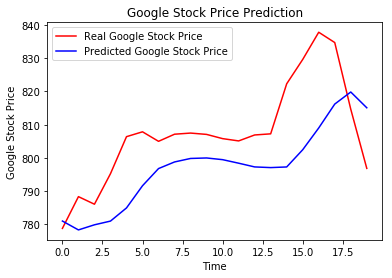

In [93]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(Bi_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

### Evaluate Model

In [94]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, Bi_pred))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 14.981391885670813.
